# Processing surfaces and points in napari - from python
[napari-process-points-and-surfaces]() (nppas) allows post-processing of surface and point cloud data. The available functionality uses [open3d](http://www.open3d.org/) in the background.
For detailed explanation of the underlying algorithms, please refer to the [open3d documentation](http://www.open3d.org/docs/release/).

In [1]:
import napari
from napari.utils import nbscreenshot
import numpy as np

from napari_process_points_and_surfaces import example_data_vedo_ellipsoid, vedo_smooth_mesh, vedo_subdivide_loop, \
                    vedo_sample_points_from_surface, vedo_subsample_points, vedo_points_to_convex_hull_surface, \
                    largest_label_to_surface, labels_to_centroids, points_to_labels, vedo_fill_holes, vedo_remove_duplicate_vertices

In [2]:
viewer = napari.Viewer(ndisplay=3)

def hide_all(viewer):
    for layer in viewer.layers:
        layer.visible = False
        
def show_all(viewer):
    for layer in viewer.layers:
        layer.visible = True

In [3]:
from skimage.data import cells3d
nuclei = cells3d()[:,1,60:120,30:80]
nuclei.shape

(60, 60, 50)

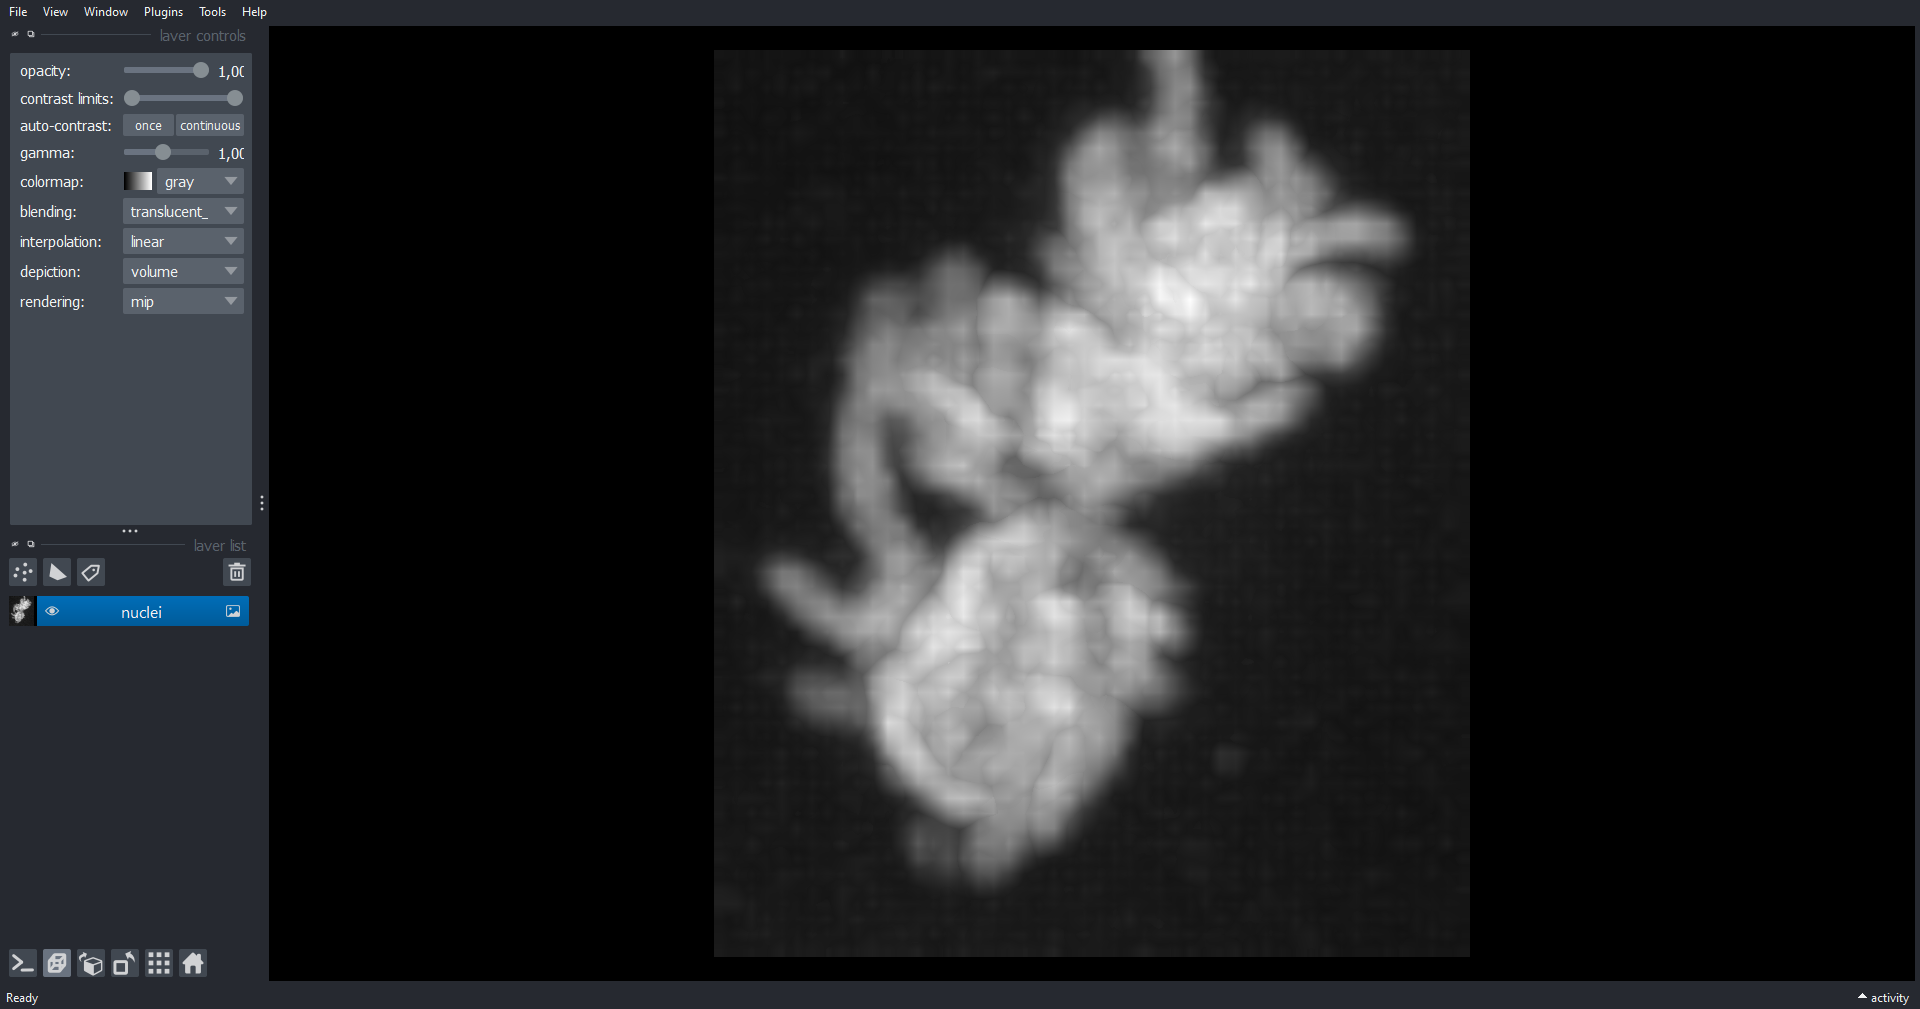

In [4]:
viewer.add_image(nuclei)

nbscreenshot(viewer)

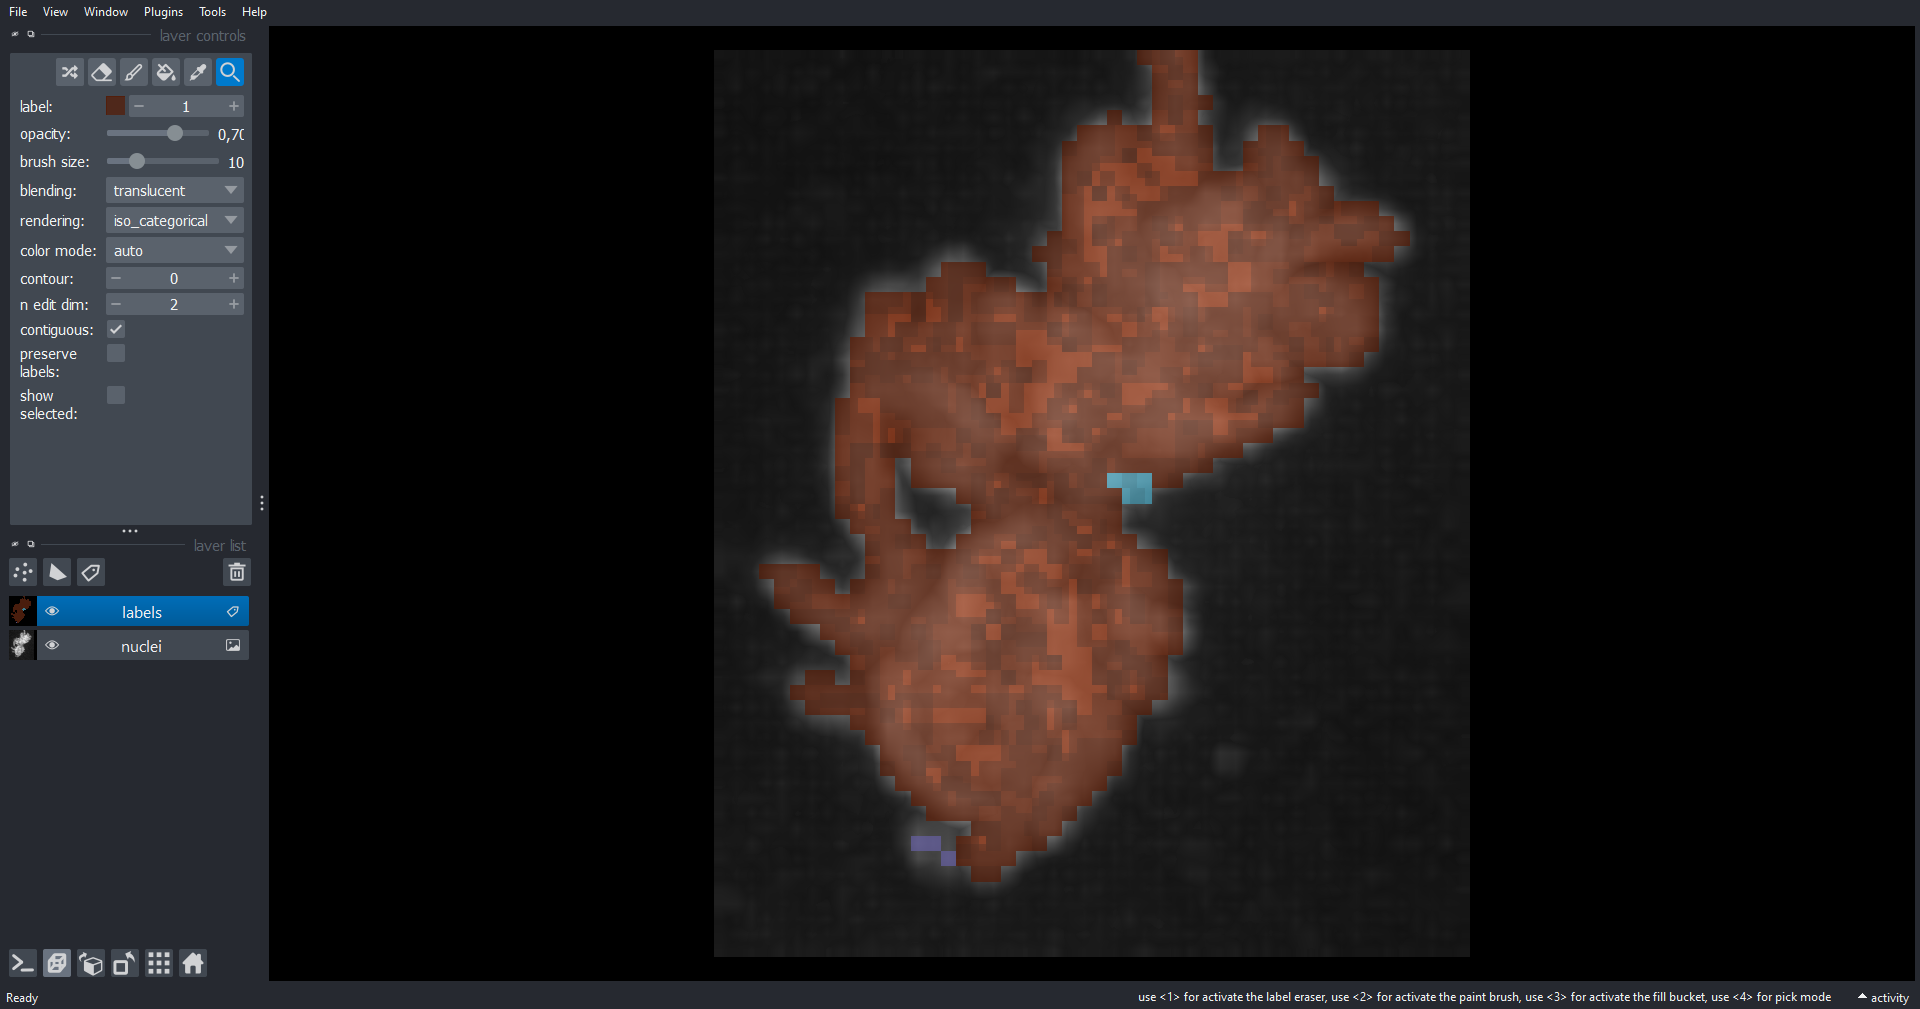

In [5]:
from skimage.measure import label
labels = label(nuclei>20000)

viewer.add_labels(labels)

nbscreenshot(viewer)

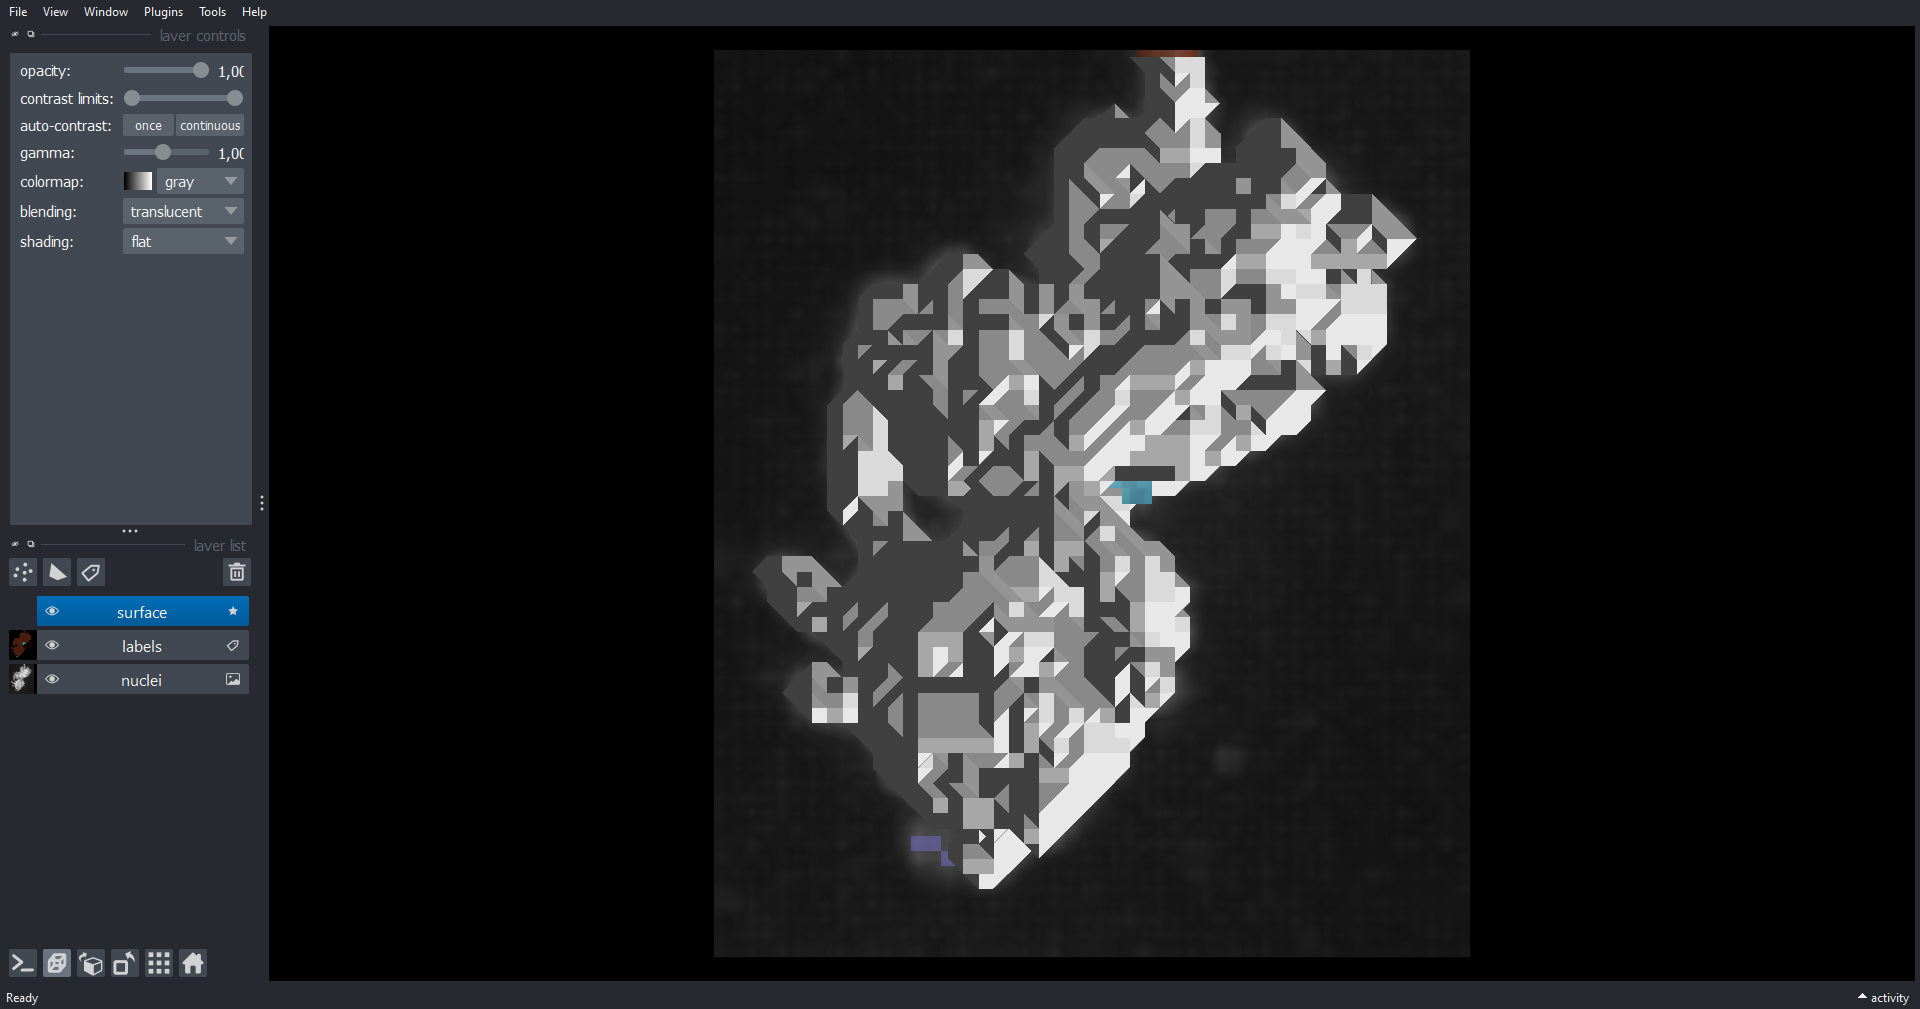

In [6]:
surface = largest_label_to_surface(labels)

surface_layer = viewer.add_surface(surface, blending='translucent', shading='flat')
surface = surface_layer.data

nbscreenshot(viewer)

## Surface filtering

Some filtering algorithms are sensitive to faults in the mesh. Such faults include duplicate faces/vertices, holes, etc. The `vedo_remove_duplicate_vertices()` function deals with this problem:

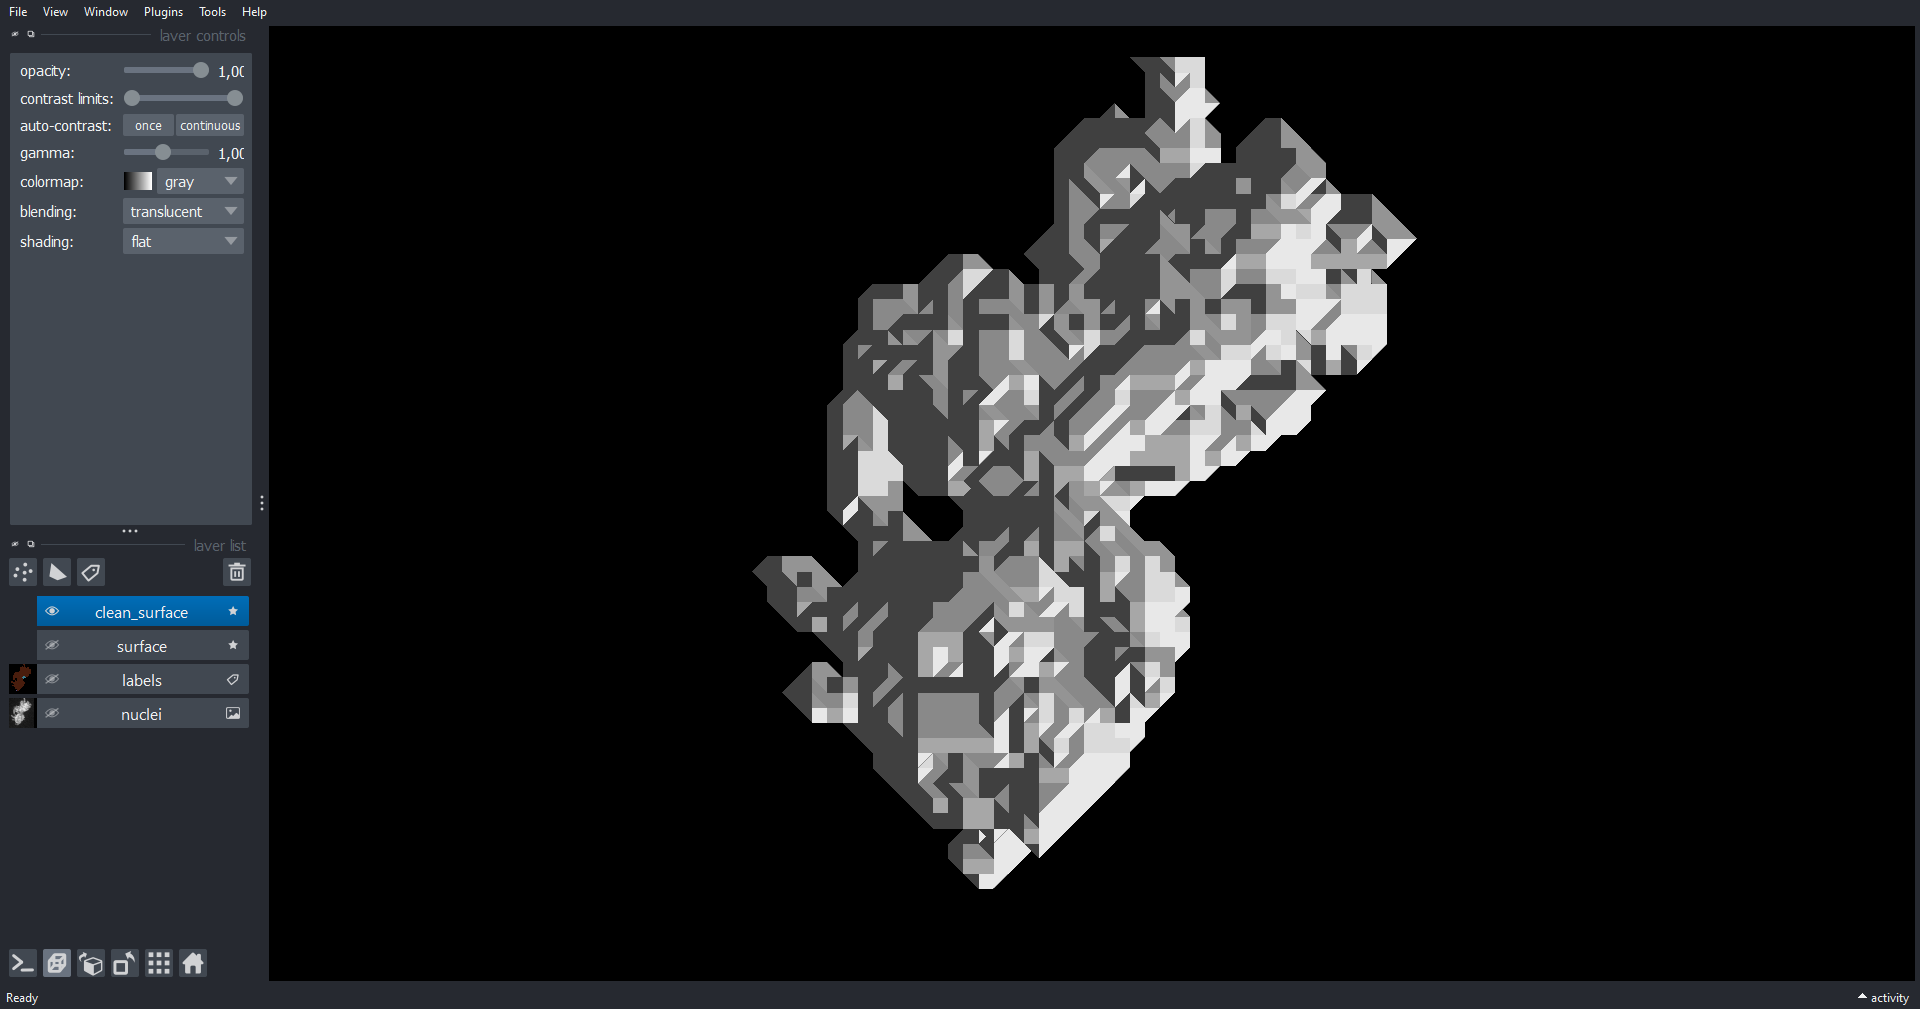

In [7]:
hide_all(viewer)

clean_surface = vedo_remove_duplicate_vertices(surface)
viewer.add_surface(clean_surface)

nbscreenshot(viewer)

After cleaning the surface, we can filter and smooth it.

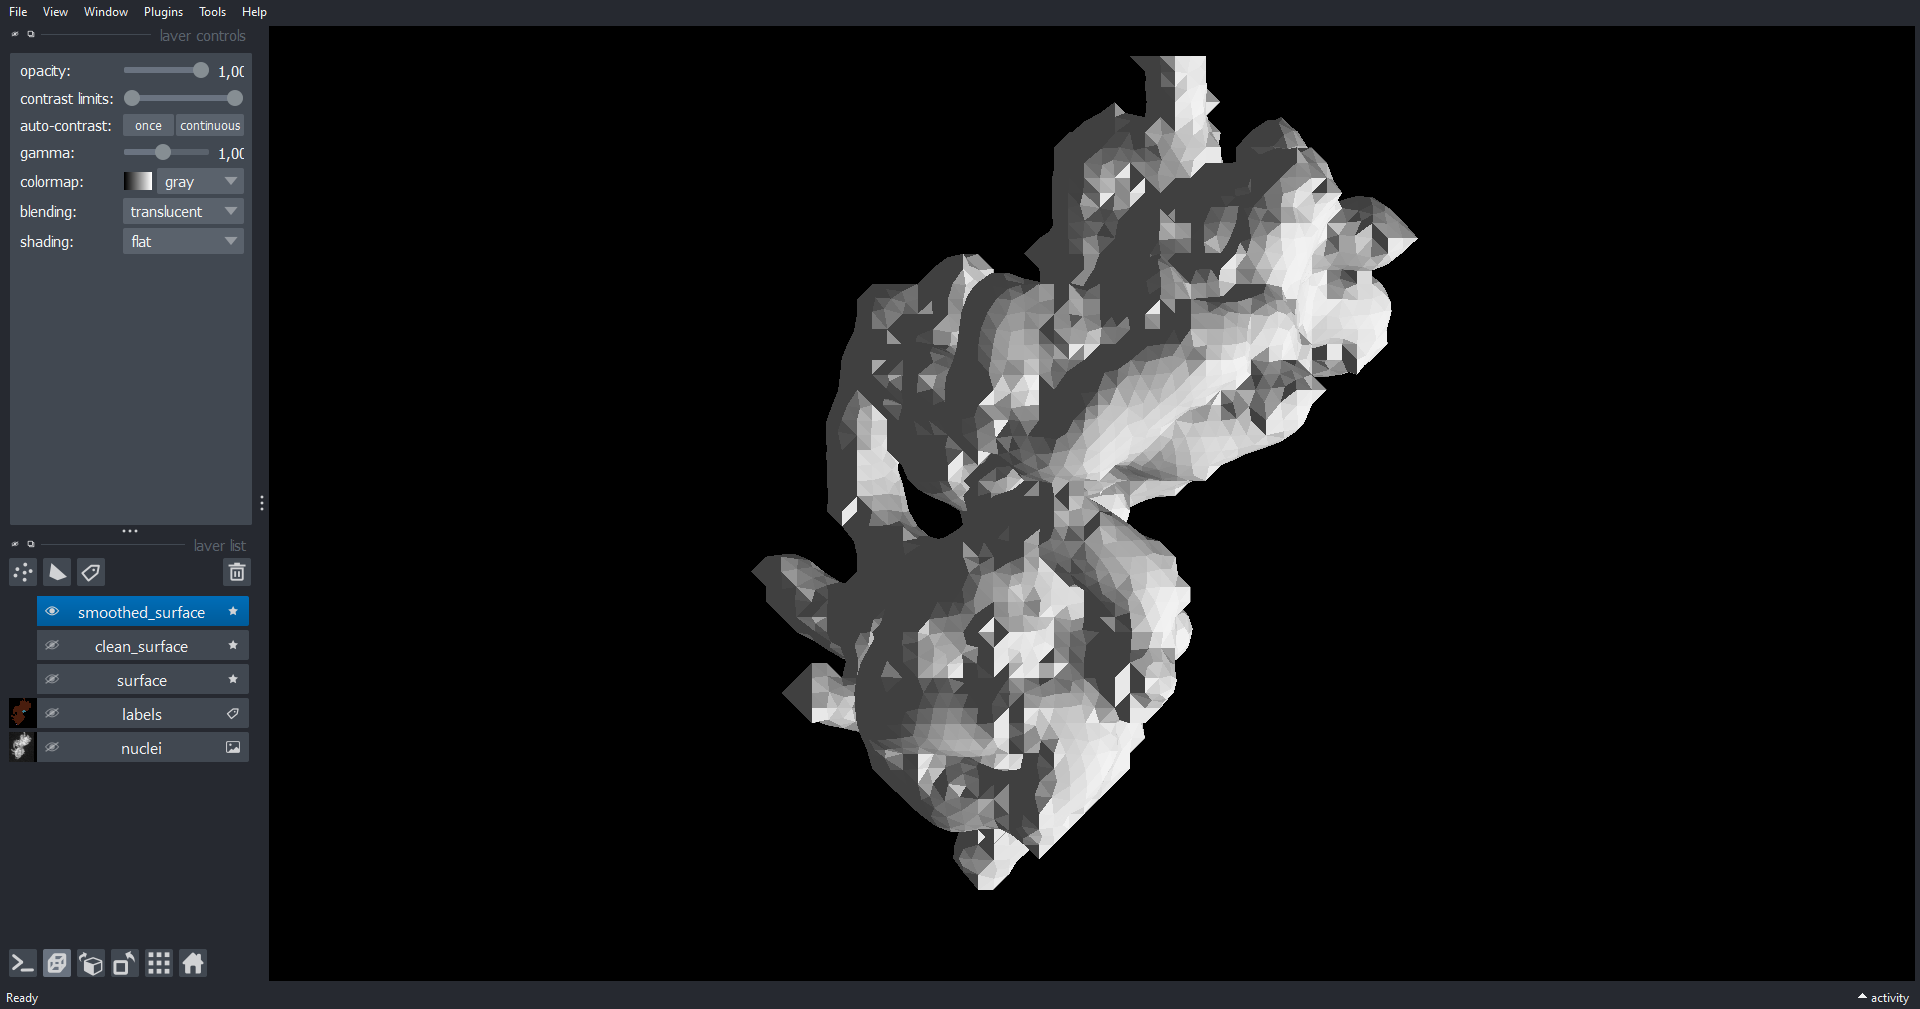

In [8]:
hide_all(viewer)

smoothed_surface = vedo_smooth_mesh(clean_surface)
viewer.add_surface(smoothed_surface)

nbscreenshot(viewer)

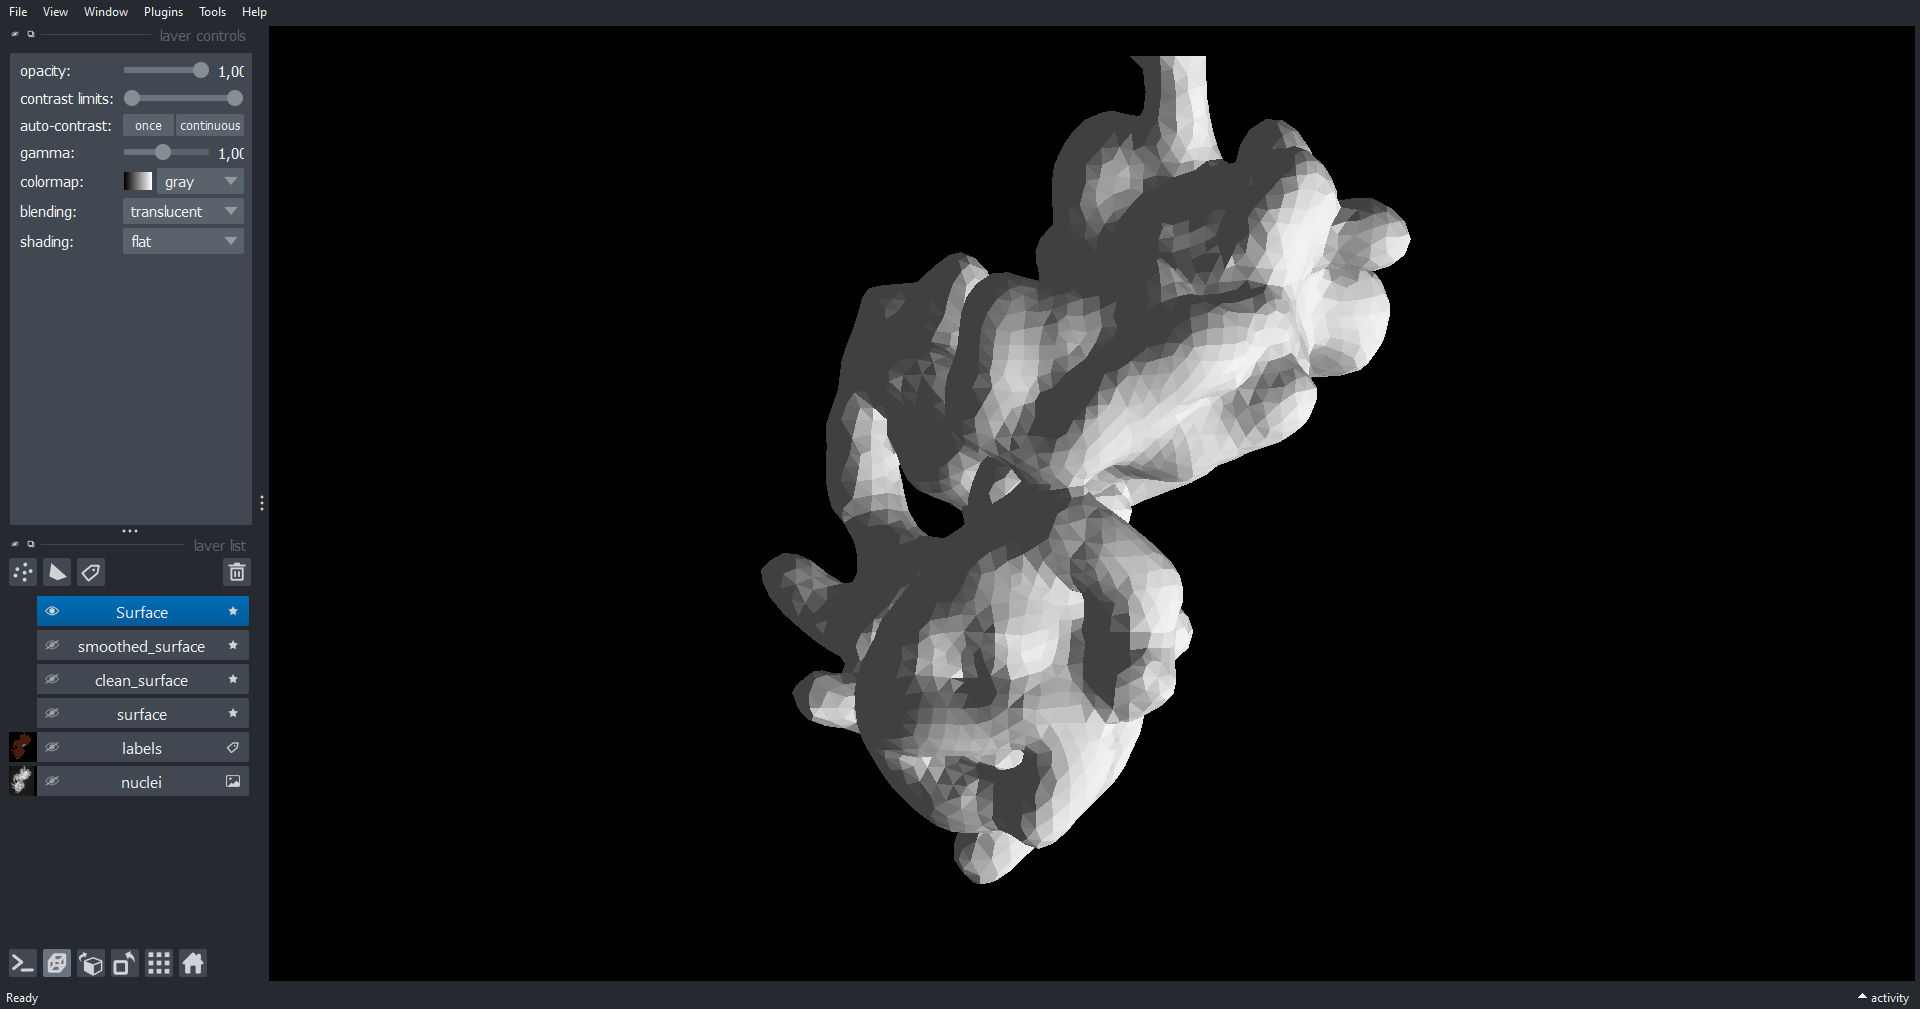

In [9]:
hide_all(viewer)

viewer.add_surface(vedo_smooth_mesh(clean_surface, feature_angle=360))

nbscreenshot(viewer)

## Surface simplification

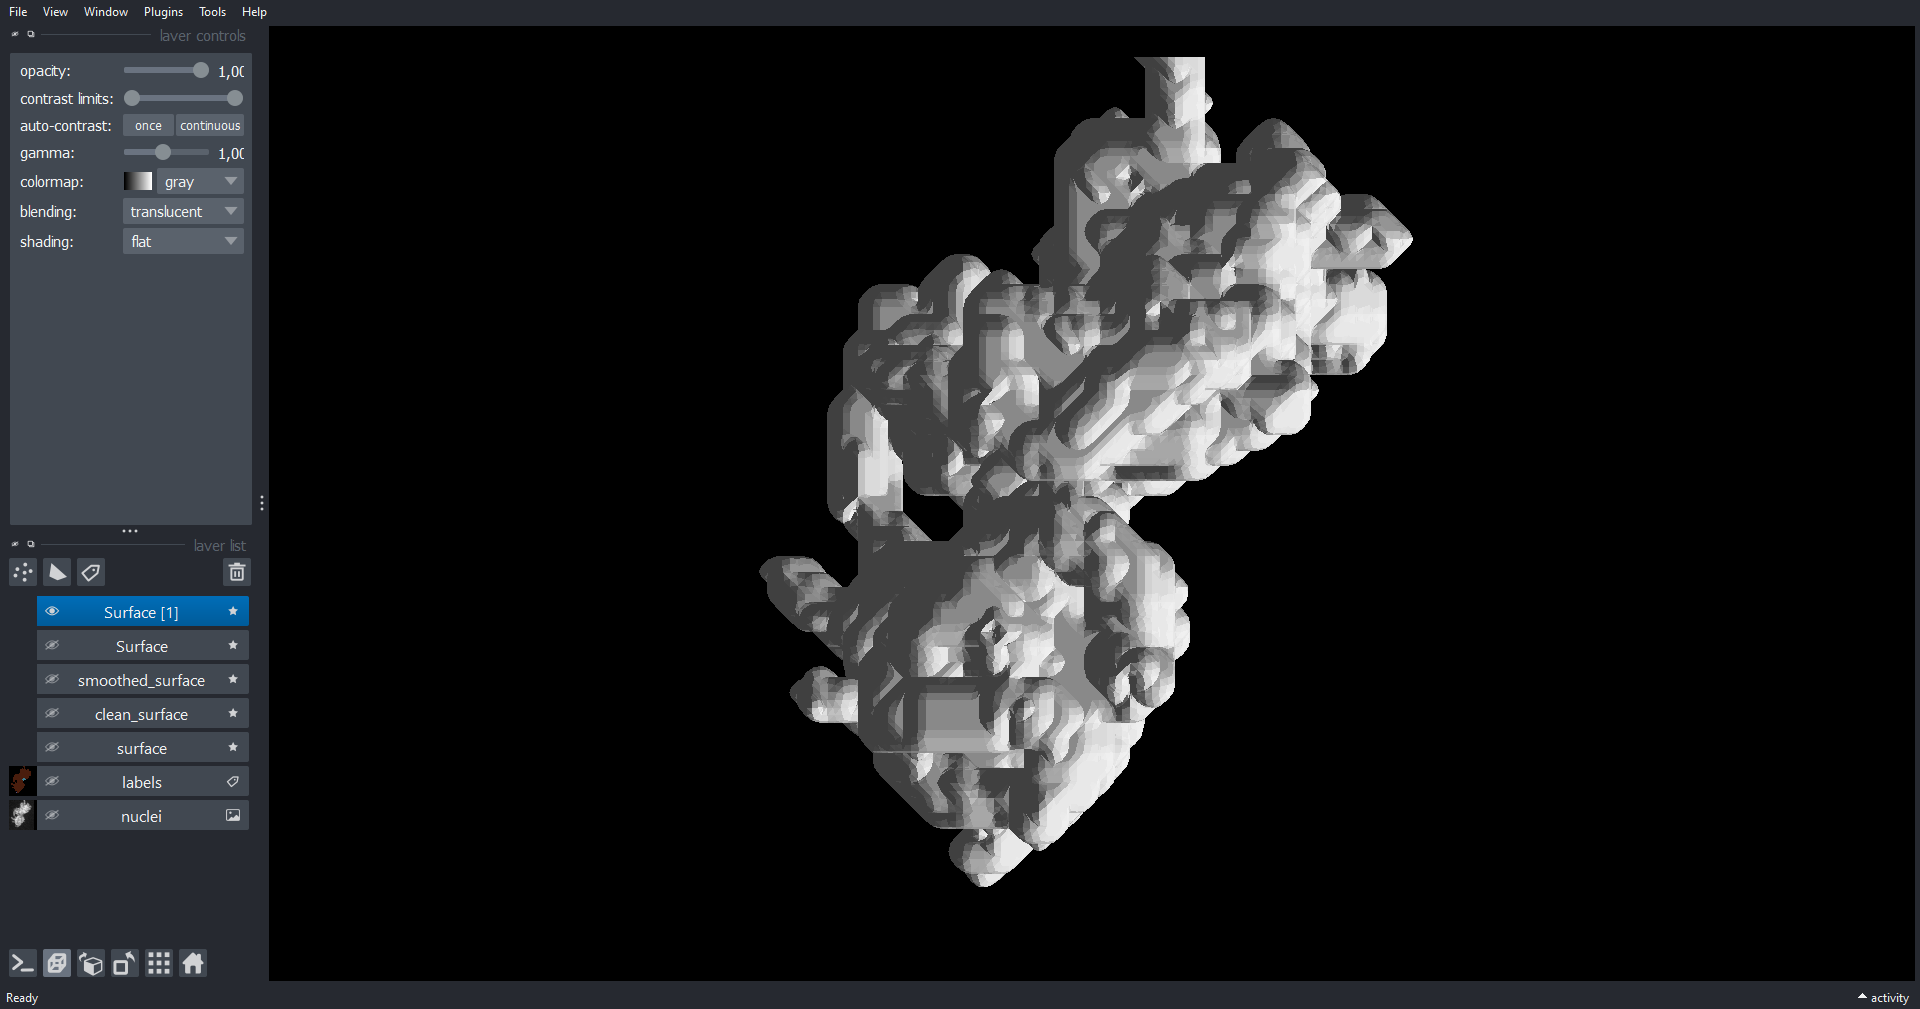

In [10]:
hide_all(viewer)

viewer.add_surface(vedo_subdivide_loop(surface))

nbscreenshot(viewer)

## Point clouds

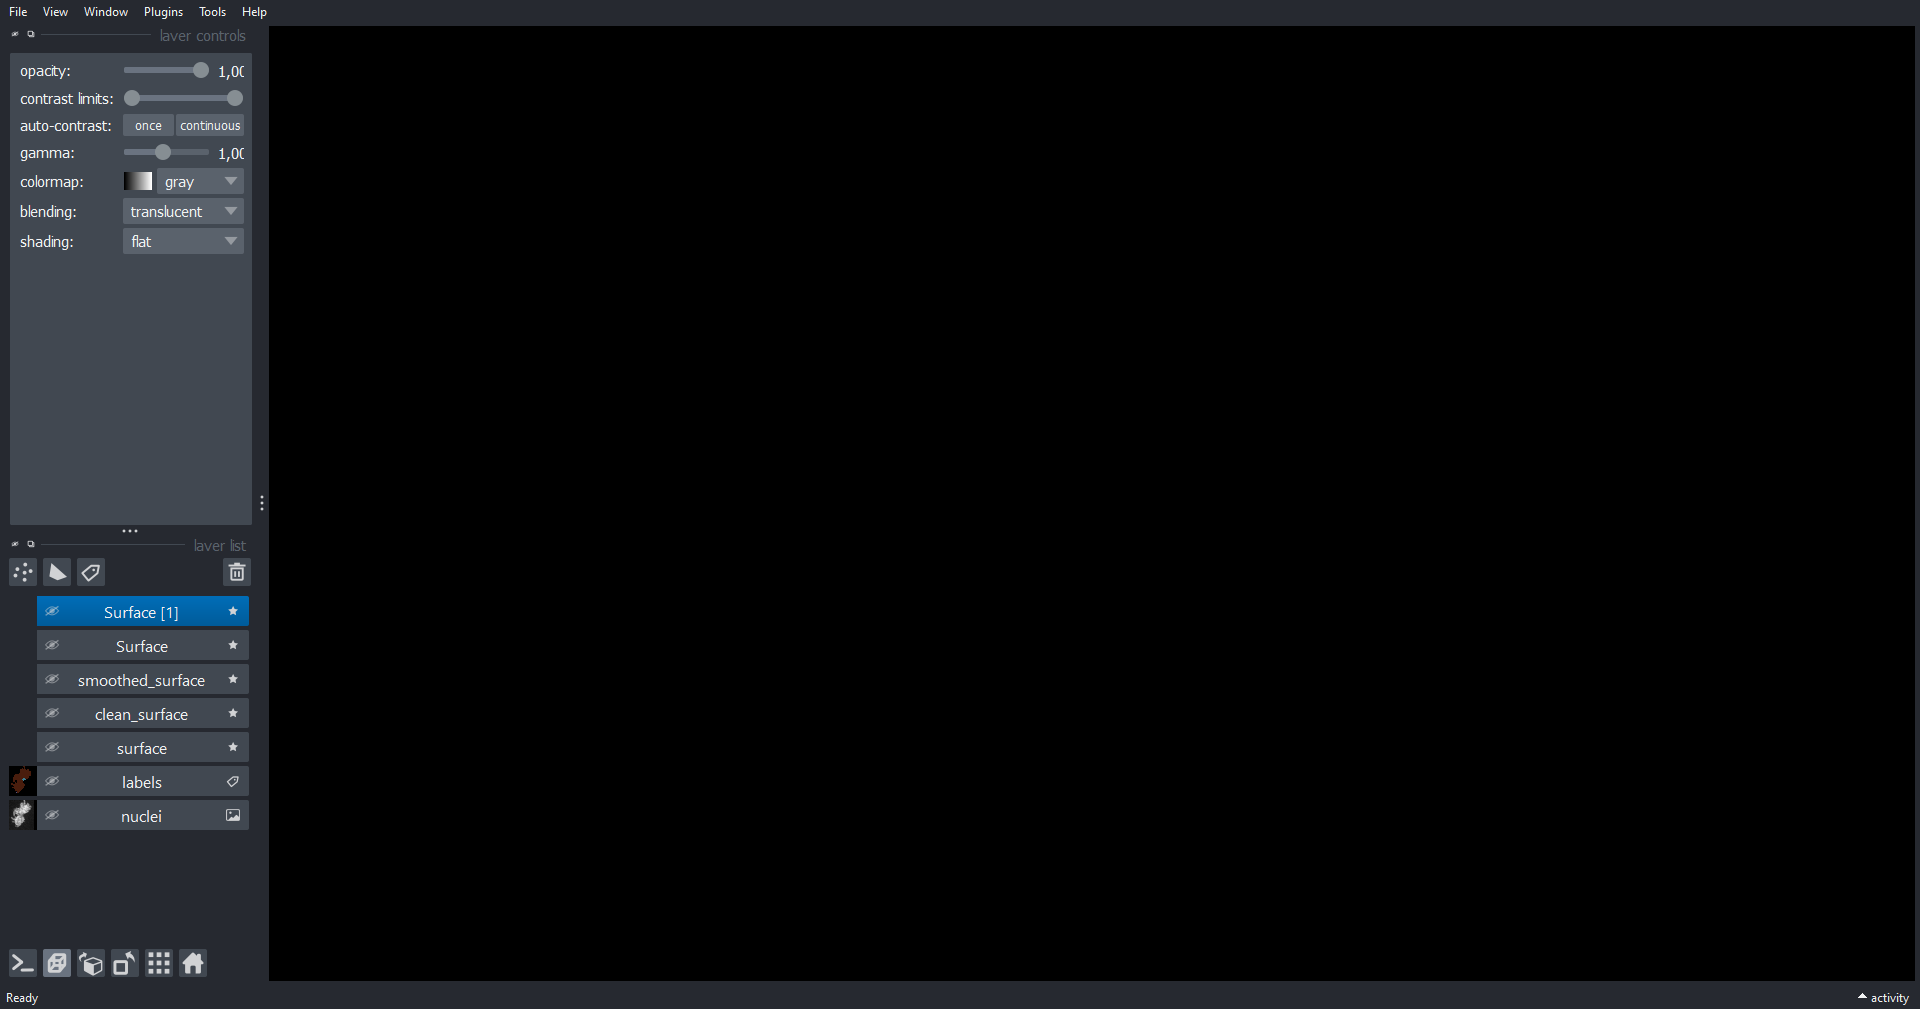

In [11]:
hide_all(viewer)

labels_to_centroids(labels, viewer=viewer)
centroids = viewer.layers[-1].data

nbscreenshot(viewer)

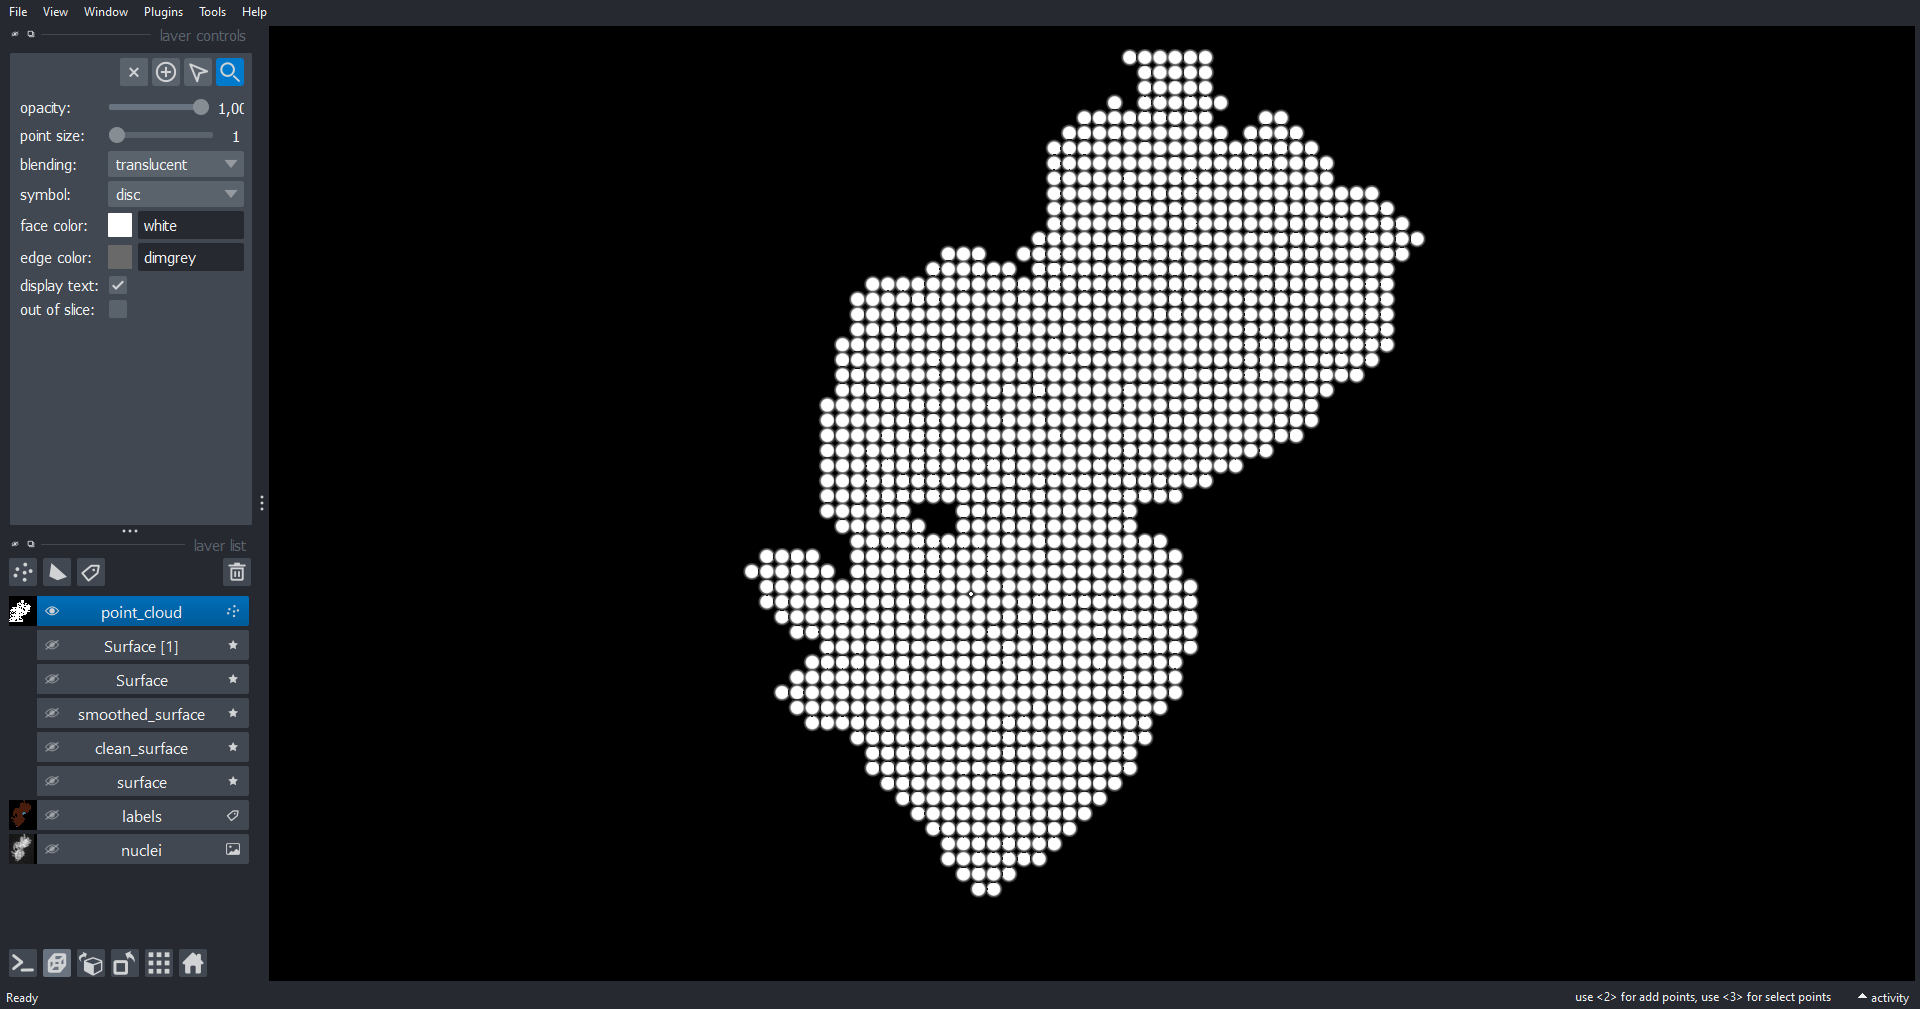

In [12]:
hide_all(viewer)
    
point_cloud = vedo_sample_points_from_surface(surface, distance_fraction=0.01)

points_layer = viewer.add_points(point_cloud, size=1)

nbscreenshot(viewer)

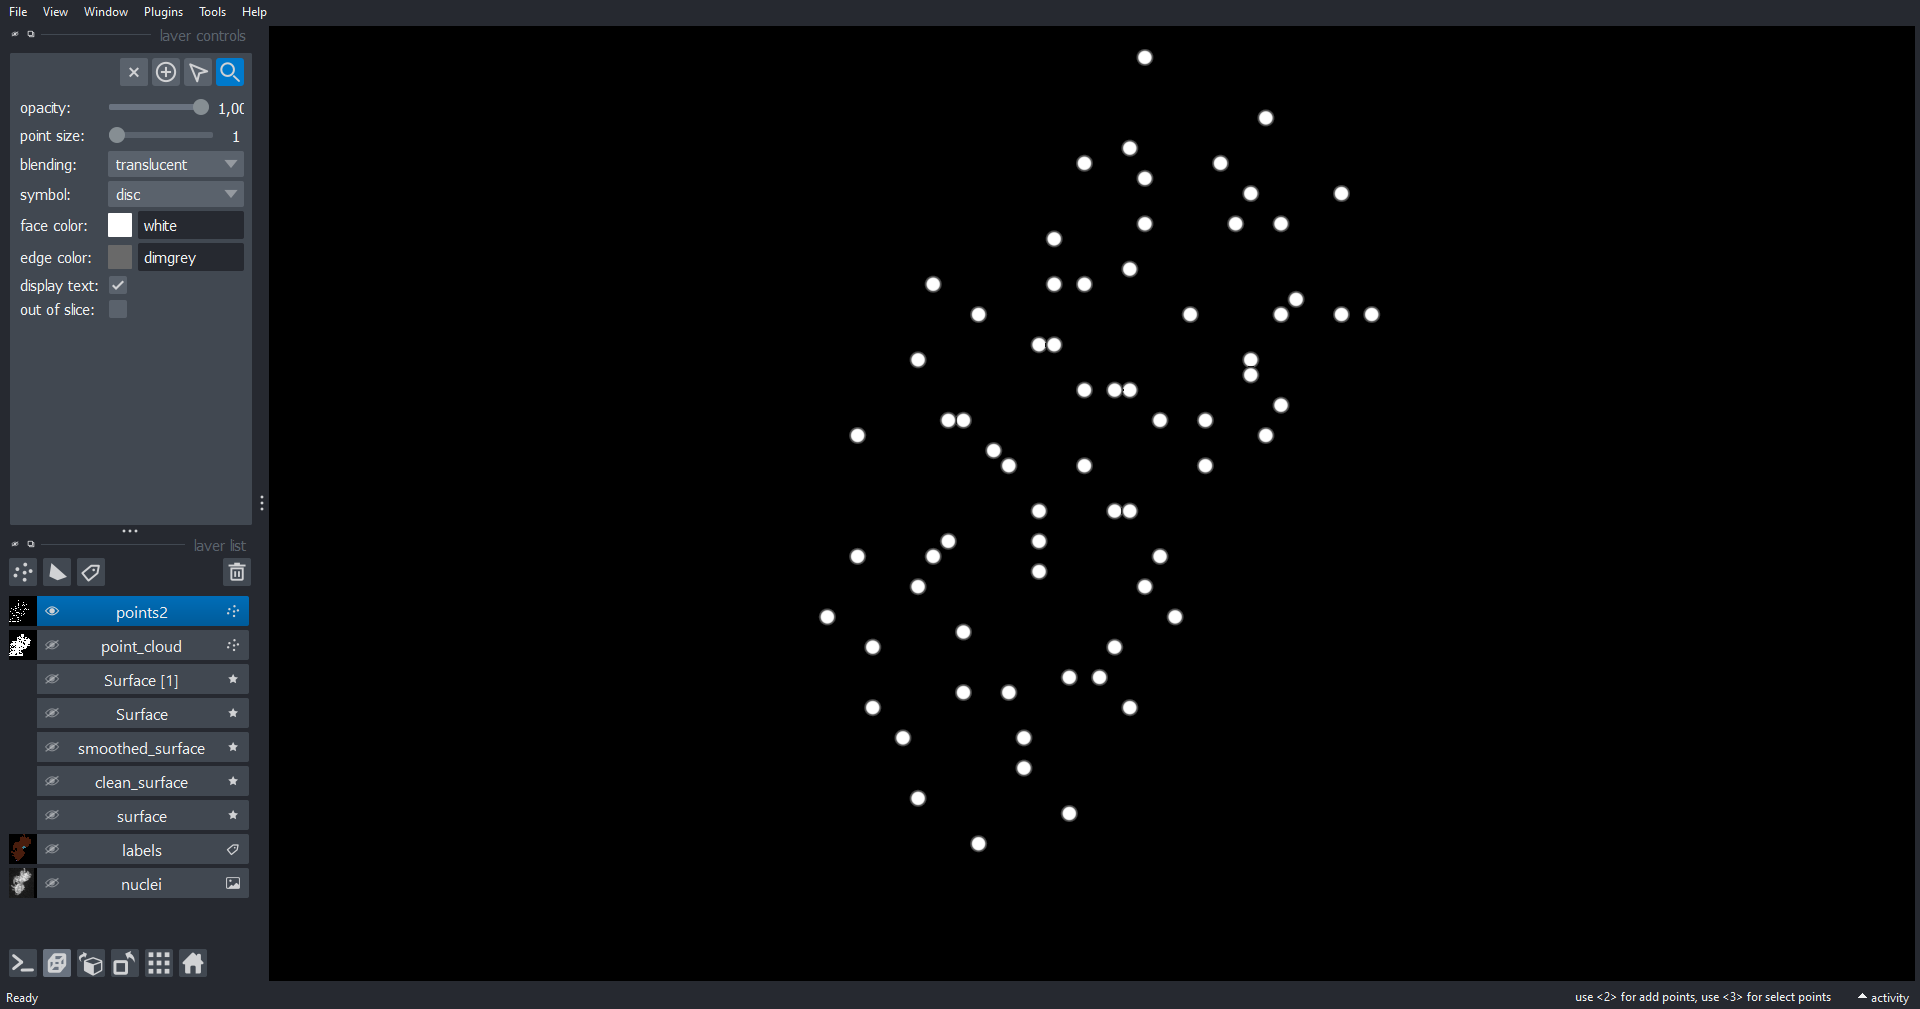

In [13]:
hide_all(viewer)
    
points2 = vedo_subsample_points(points_layer.data, distance_fraction=0.1)

viewer.add_points(points2, size=1)

nbscreenshot(viewer)

## From points to labels

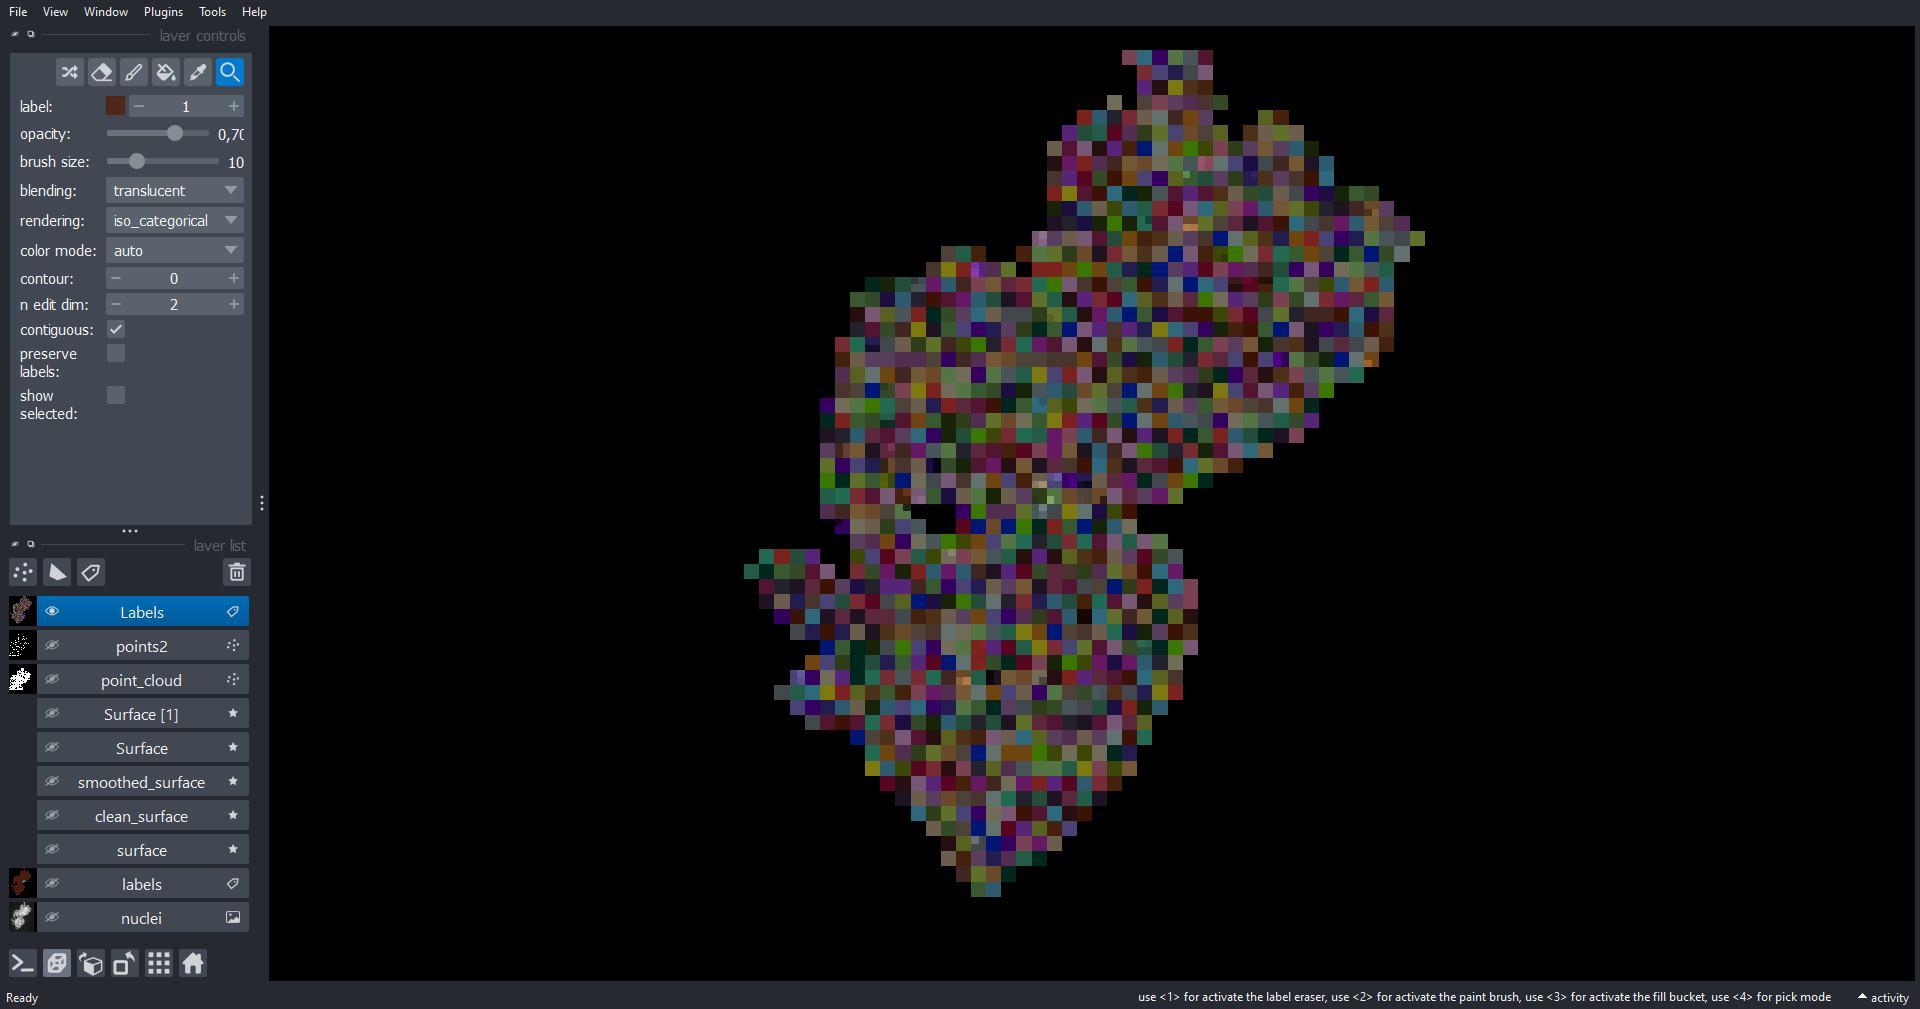

In [14]:
hide_all(viewer)

viewer.add_labels(points_to_labels(points_layer.data, labels))

nbscreenshot(viewer)

## From points to surfaces

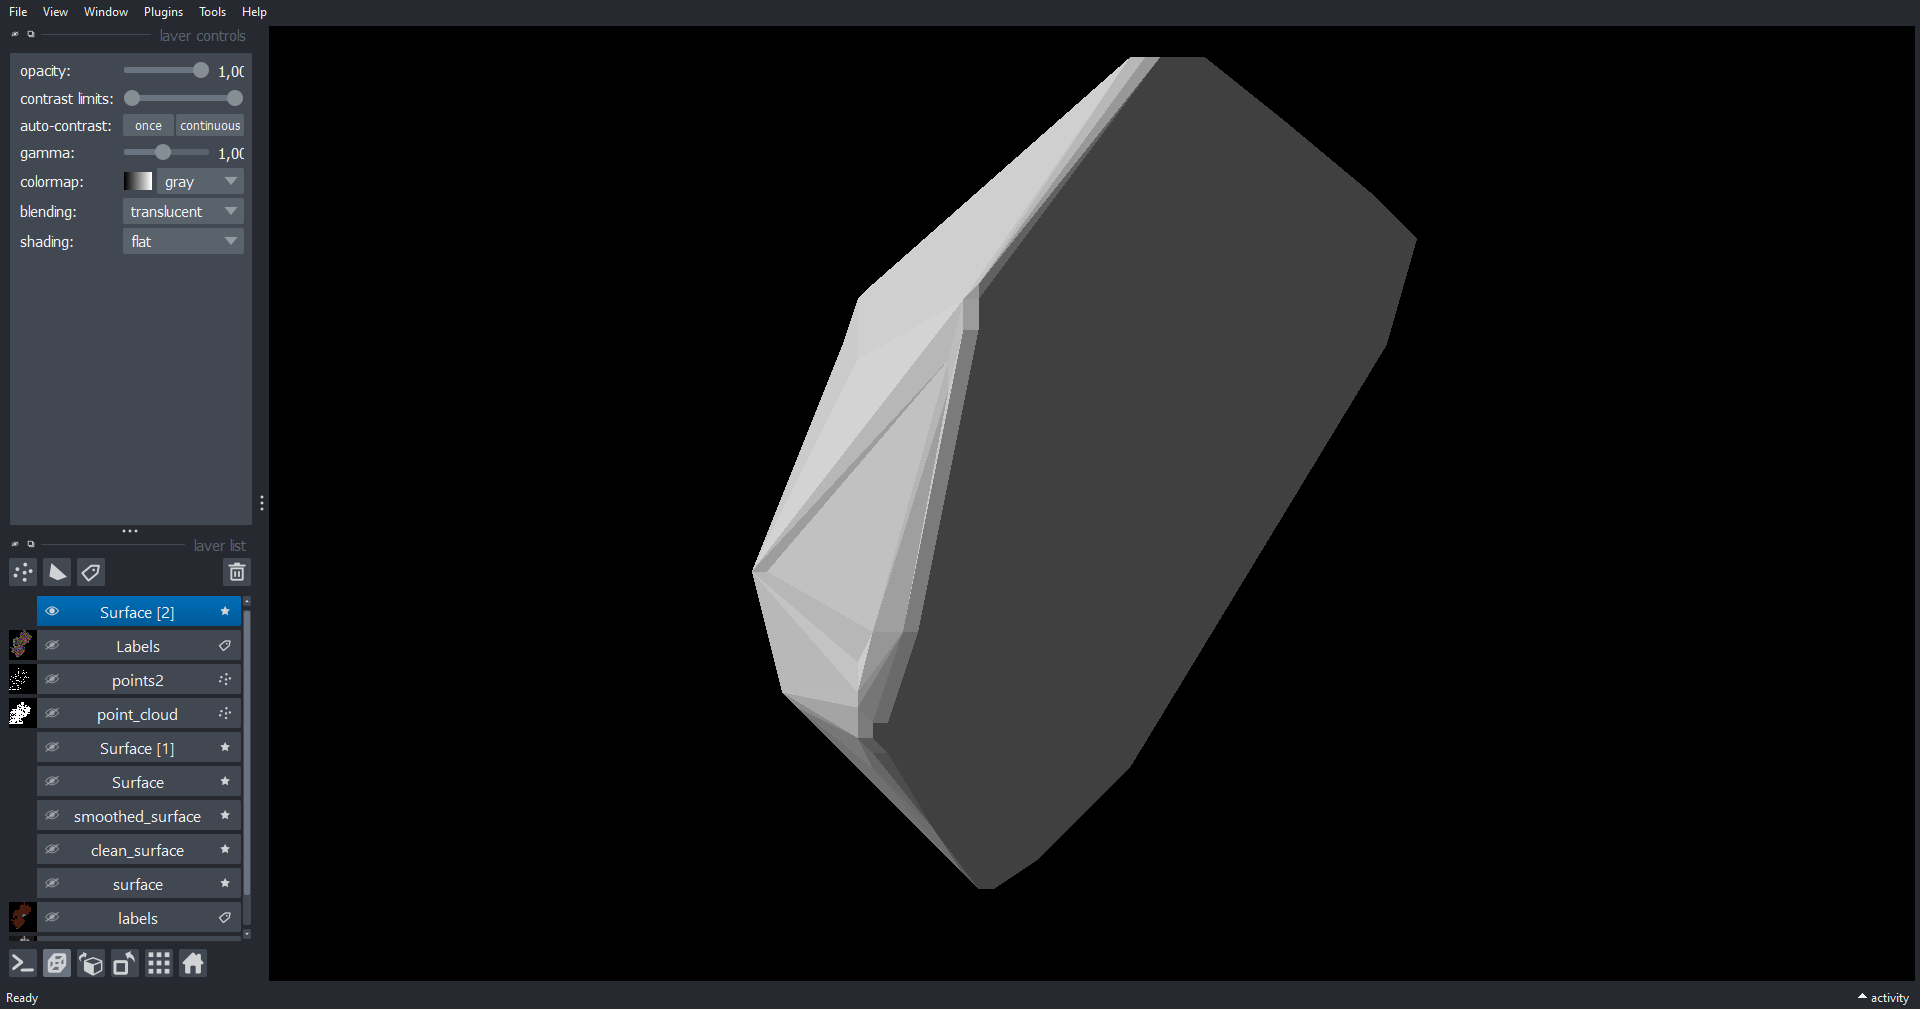

In [15]:
hide_all(viewer)

viewer.add_surface(vedo_points_to_convex_hull_surface(points_layer.data))

nbscreenshot(viewer)

## Filling holes

In [16]:
hide_all(viewer)

To demonstrate what's happening, we first make a copy of the previously generated convex hull and delete some of the faces:

In [17]:
surface = vedo_points_to_convex_hull_surface(points_layer.data)
points = surface[0]
faces = surface[1]

In [18]:
n_deleted_faces = 30
np.random.seed = 1
faces_with_holes = np.delete(faces, [102, 103], axis=0)
surface_with_hole = (points, faces_with_holes)

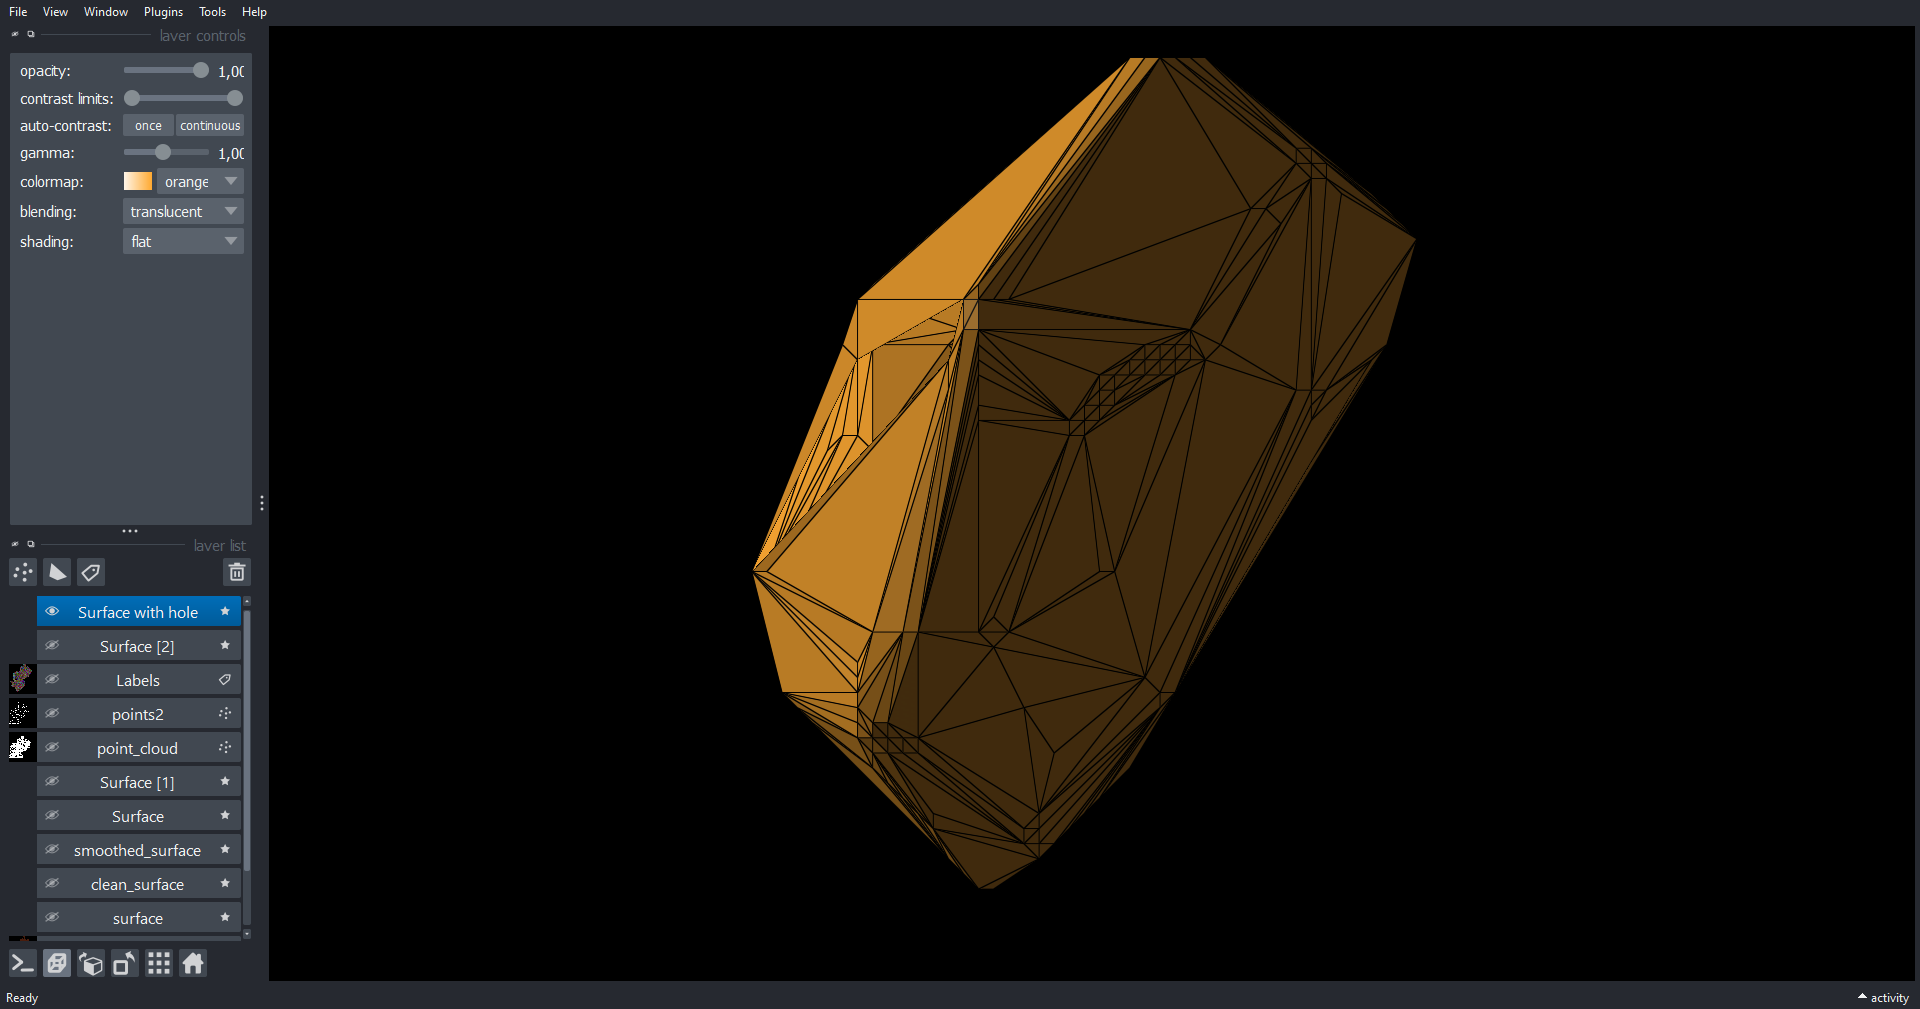

In [19]:
viewer.add_surface(surface_with_hole, name='Surface with hole', colormap='orange')
viewer.layers[-1].wireframe.visible = True
nbscreenshot(viewer)

**Note:** The following cell fills the previously generated holes in the mesh. However, the filled-in triangles may still stand out from the surrounding of the mesh, which can be an effect of opposing normal vectors of neighboring triangles.

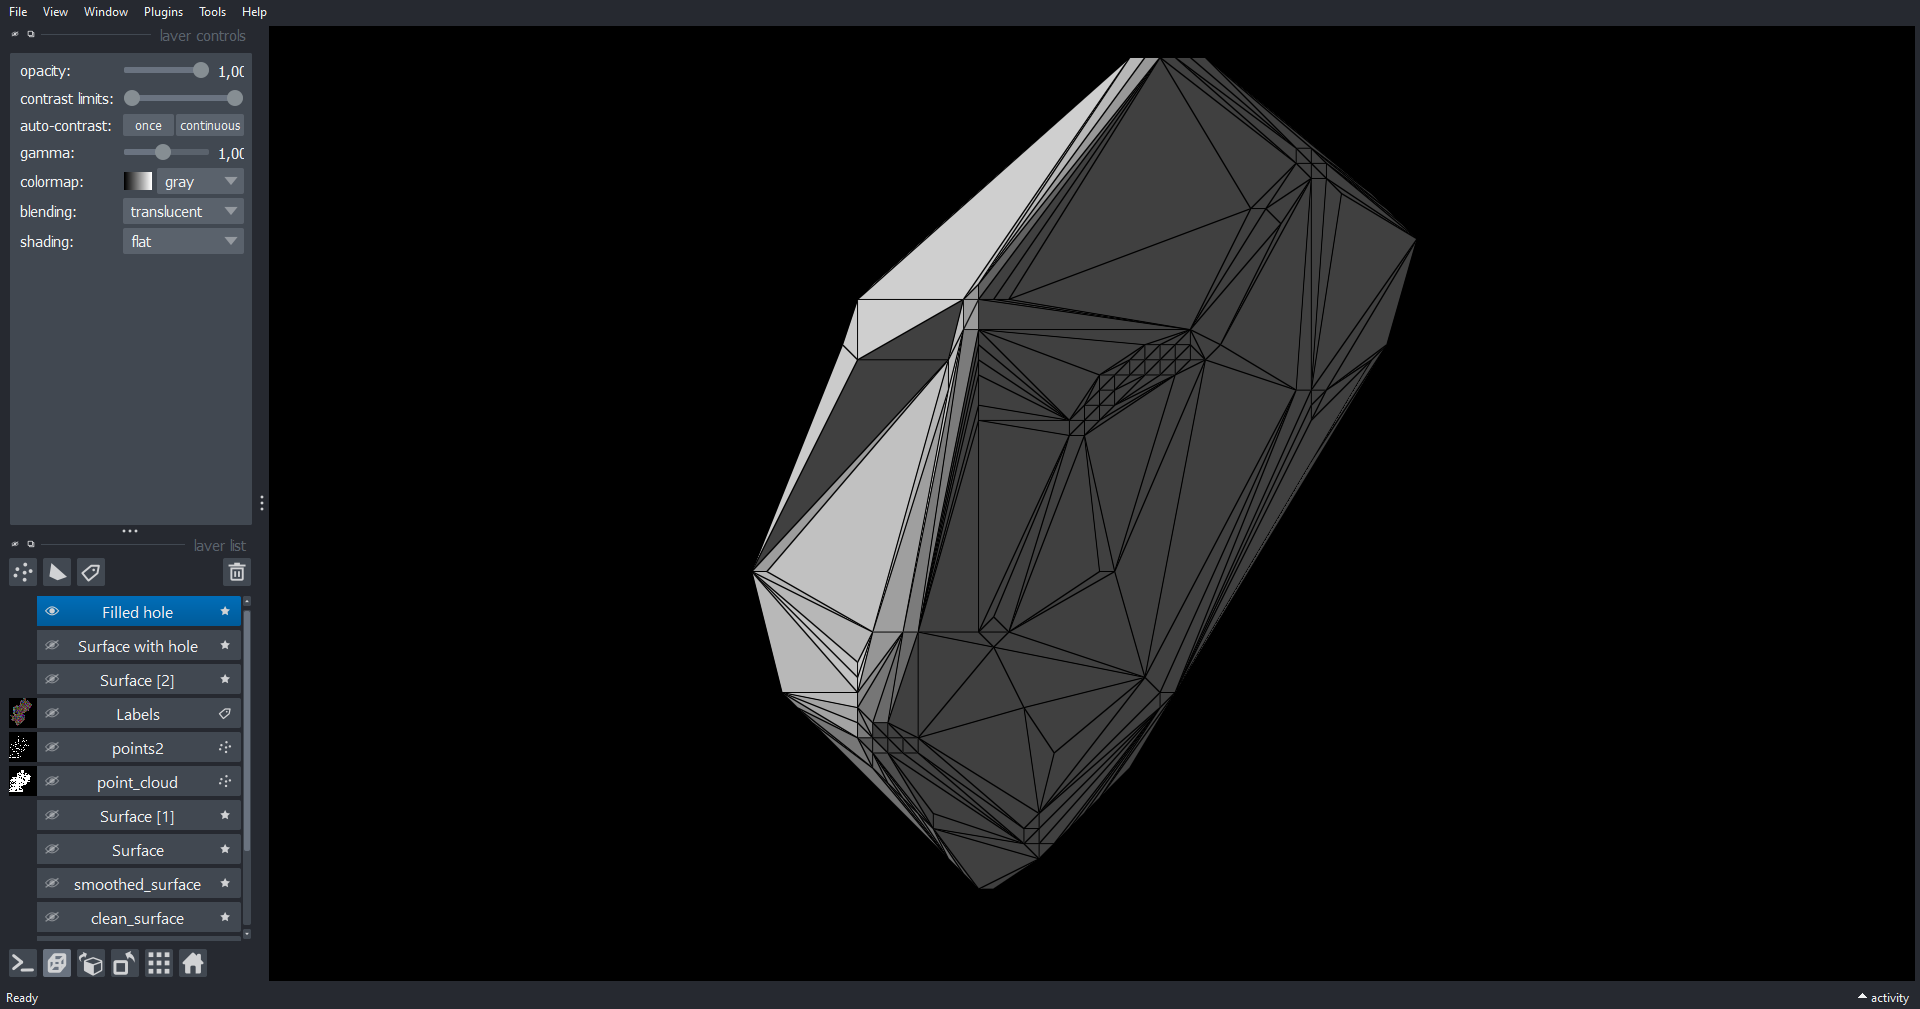

In [20]:
hide_all(viewer)
viewer.add_surface(vedo_fill_holes(surface_with_hole, size_limit=100000), name='Filled hole')
viewer.layers[-1].wireframe.visible = True
nbscreenshot(viewer)

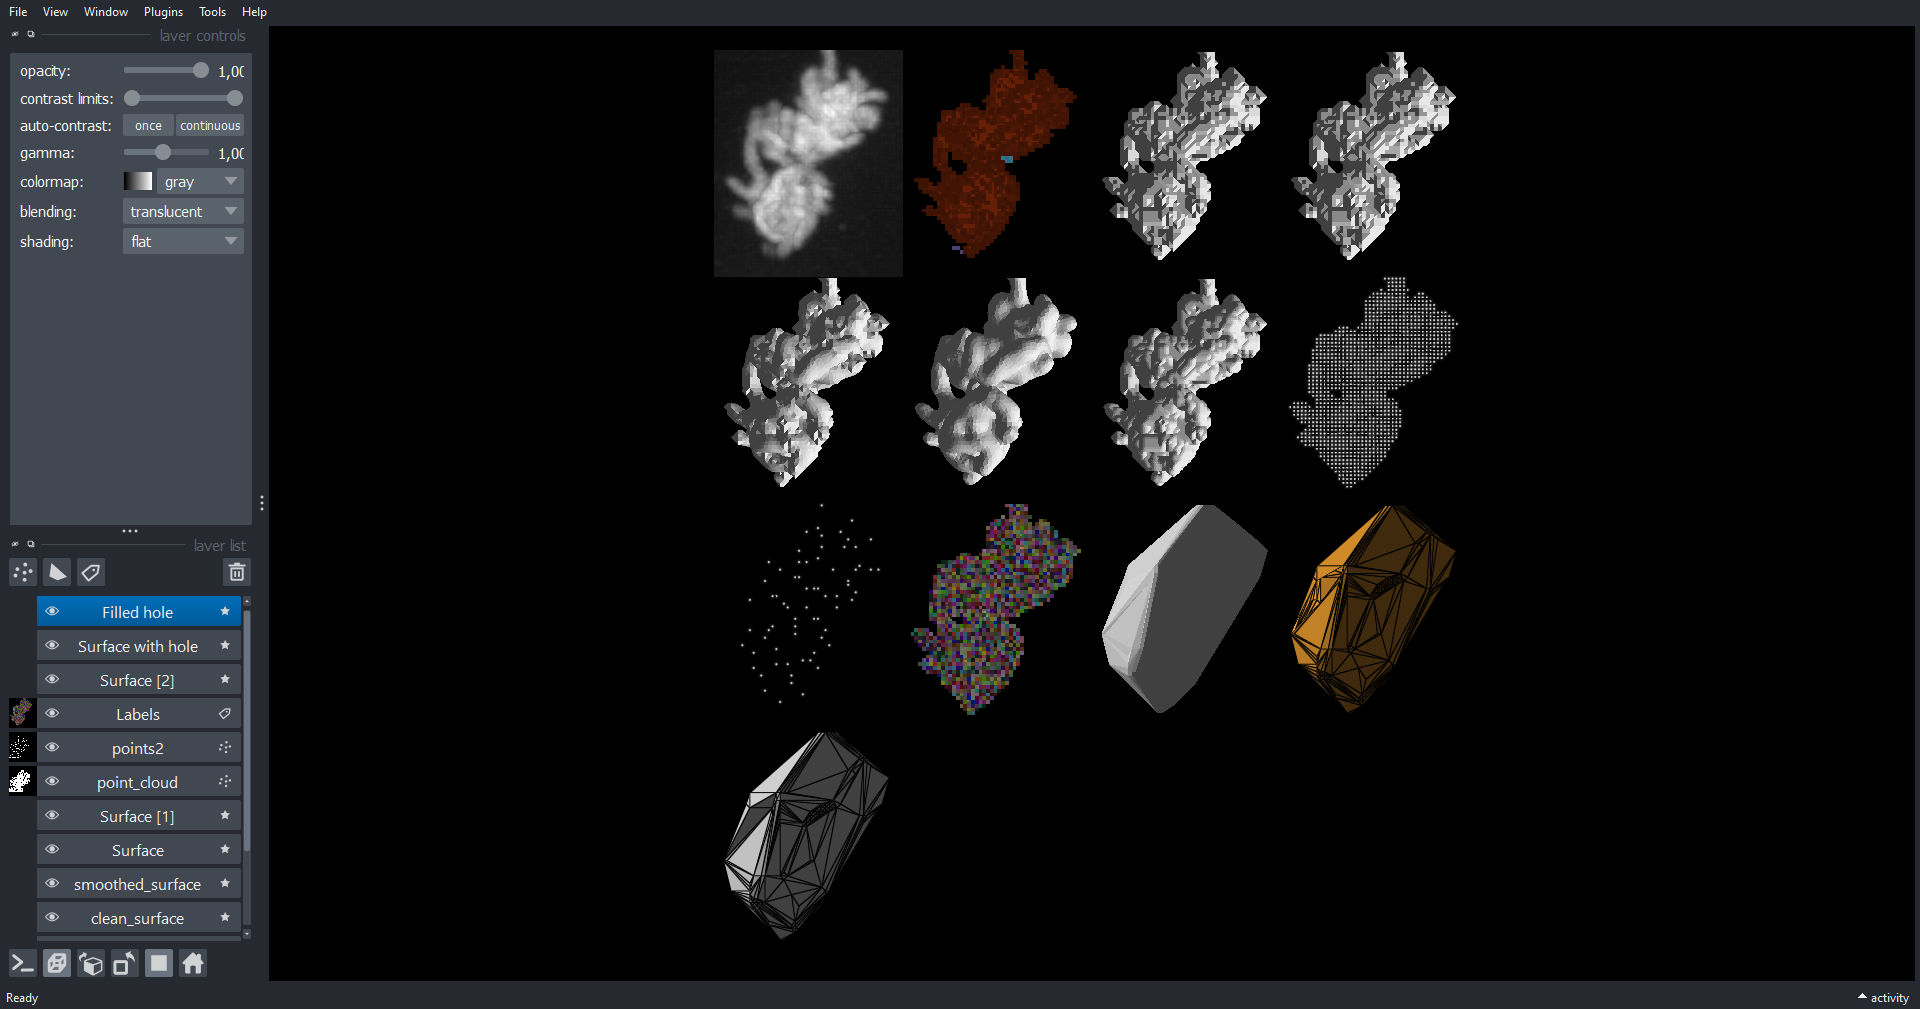

In [21]:
show_all(viewer)

viewer.grid.enabled = True
viewer.grid.stride = -1

nbscreenshot(viewer)